In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor

In [ ]:
# Load dataset from UCI
df = fetch_ucirepo(id=360)
raw_df = df.data.original.copy()
print("\nOriginal Dataset Shape:", raw_df.shape)

# Preview data
print("\nFirst 5 rows of data:")
print(raw_df.head())

print("\nDataset Info:")
print(raw_df.info())


Original Dataset Shape: (9357, 15)

First 5 rows of data:
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  

In [ ]:
# Select subset of columns
cols_to_use = [
    'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
    'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH','CO(GT)'
]
raw_df = raw_df[cols_to_use]
print("\nShape after selecting relevant columns:", raw_df.shape)


Shape after selecting relevant columns: (7344, 9)


In [ ]:
# Count -200 values (missing codes)
print("\nNumber of -200 values in each column before cleaning:")
print((raw_df == -200).sum())

# Handle missing values
raw_df = raw_df.replace(-200, np.nan).dropna()
print("\nShape after dropping rows with missing values:", raw_df.shape)

# Null check
print("\nMissing values after cleaning:")
print(raw_df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(raw_df.describe())


Number of -200 values in each column before cleaning:
PT08.S1(CO)      0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
CO(GT)           0
dtype: int64

Shape after dropping rows with missing values: (7344, 9)

Missing values after cleaning:
PT08.S1(CO)      0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
CO(GT)           0
dtype: int64

Summary Statistics:
       PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7344.000000    7344.000000   7344.000000   7344.000000  7344.000000   
mean   1110.580746     947.198121    826.920071   1444.752723  1043.512936   
std     218.681331     265.471608    256.648430    350.344170   405.569613   
min     647.000000     387.000000    322.000000    551.000000   221.000000   
25%     946.000000     743.000000    649.000000   1203.000000   744.750000  

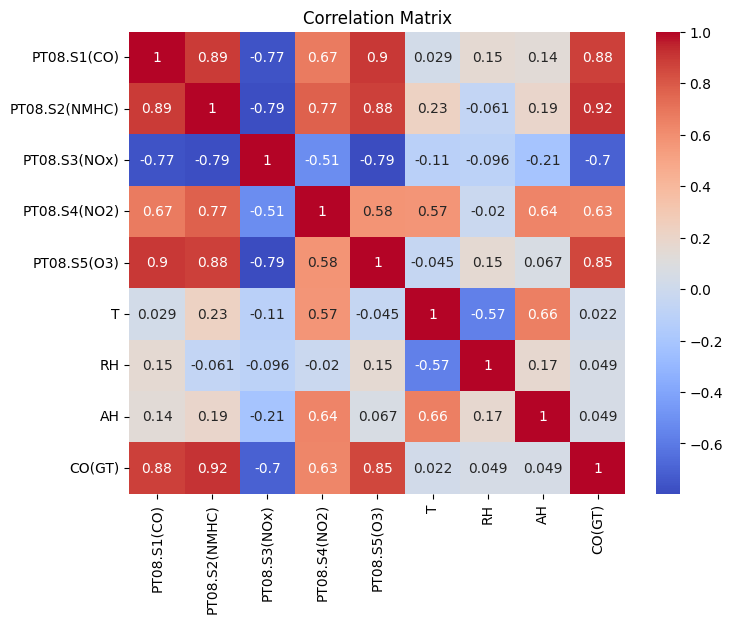

In [ ]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(raw_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Features and target
features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
            'PT08.S4(NO2)', 'PT08.S5(O3)']
X = raw_df[features].values
y = raw_df['CO(GT)'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("\nTrain Shape:", X_train.shape, "Test Shape:", X_test.shape)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train Shape: (5875, 5) Test Shape: (1469, 5)


In [49]:
etas = [0.001, 0.01, 0.05, 0.1, 0.5]
learning_rates = ["constant", "optimal", "invscaling", "adaptive"]
penalties = ["l2", "l1", "elasticnet"]
results = []

for eta in etas:
    for lr in learning_rates:
        for pen in penalties:
            sgd = SGDRegressor(
                max_iter=1000,
                tol=1e-3,
                random_state=42,
                eta0=eta,
                learning_rate=lr,
                penalty=pen
            )
            # Fit the model
            sgd.fit(X_train_scaled, y_train)

            # Predictions
            y_train_pred = sgd.predict(X_train_scaled)
            y_test_pred = sgd.predict(X_test_scaled)

            # Store results
            results.append({
                "eta0": eta,
                "learning_rate": lr,
                "penalty": pen,
                "Train MSE": mean_squared_error(y_train, y_train_pred),
                "Test MSE": mean_squared_error(y_test, y_test_pred),
                "R2": r2_score(y_test, y_test_pred),
                "Explained Variance": explained_variance_score(y_test, y_test_pred)
            })

# Saves results to CSV
results_df = pd.DataFrame(results)       # Convert dictionary to DataFrame
results_df.to_csv("sgd_log.csv", index=False)  # Write DataFrame to CSV without the index

print("Results saved to sgd_log.csv")


Results saved to sgd_log.csv


In [ ]:
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df.sort_values(by="R2", ascending=False).round(4))
best_idx = np.argmax(results_df["R2"])
best_row = results_df.iloc[best_idx]

print("\nBest Model:")
print(best_row)


All Results:
     eta0 learning_rate     penalty     Train MSE      Test MSE            R2  \
21  0.010      adaptive          l2  2.569000e-01  2.125000e-01  8.911000e-01   
23  0.010      adaptive  elasticnet  2.569000e-01  2.125000e-01  8.911000e-01   
22  0.010      adaptive          l1  2.569000e-01  2.125000e-01  8.911000e-01   
57  0.500      adaptive          l2  2.569000e-01  2.125000e-01  8.911000e-01   
58  0.500      adaptive          l1  2.569000e-01  2.125000e-01  8.911000e-01   
45  0.100      adaptive          l2  2.569000e-01  2.125000e-01  8.911000e-01   
59  0.500      adaptive  elasticnet  2.569000e-01  2.125000e-01  8.911000e-01   
47  0.100      adaptive  elasticnet  2.569000e-01  2.125000e-01  8.911000e-01   
46  0.100      adaptive          l1  2.569000e-01  2.125000e-01  8.911000e-01   
33  0.050      adaptive          l2  2.569000e-01  2.125000e-01  8.911000e-01   
35  0.050      adaptive  elasticnet  2.569000e-01  2.125000e-01  8.911000e-01   
34  0.050     

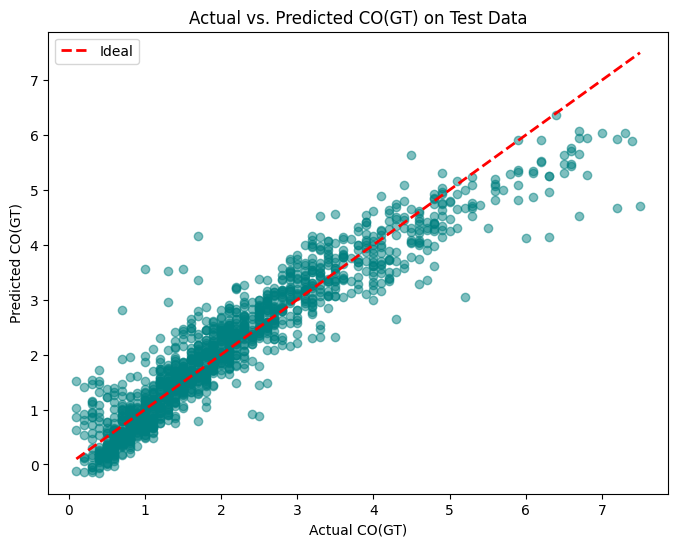

In [ ]:
# Initialize the best SGDRegressor model using the hyperparameters from the best_row
best_model = SGDRegressor(
  max_iter=1000,
  tol=1e-3,
  random_state=42,
  eta0= best_row["eta0"],
  learning_rate= best_row["learning_rate"],
  penalty= best_row["penalty"]
)

best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        color='red', linestyle='--', linewidth=2, label='Ideal')
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title("Actual vs. Predicted CO(GT) on Test Data")
plt.legend()
plt.show()

In [ ]:
import statsmodels.api as sm

In [ ]:
# Add a constant (bias/intercept) column
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

# Fit the model to the training data
ols_model = sm.OLS(y_train, X_train_const).fit()

# Print the summary
print(ols_model.summary())

# Predict on test set
y_test_pred = ols_model.predict(X_test_const)

# Evaluate
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"\nOLS Test MSE: {mse:.4f}")
print(f"OLS Test R²: {r2:.4f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     8381.
Date:                Sun, 21 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:28:33   Log-Likelihood:                -4343.7
No. Observations:                5875   AIC:                             8699.
Df Residuals:                    5869   BIC:                             8739.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1359      0.007    322.854      0.0